In [1]:
# 导入必要的库
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 定义数据集类
class HotelSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # 使用tokenizer对文本进行编码
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }

# 创建平衡数据集的函数
def create_balanced_dataset(df, size=None):
    """创建平衡数据集"""
    positive = df[df.label == 1]
    negative = df[df.label == 0]

    if size:
        sample_size = size // 2
        positive = positive.sample(sample_size, replace=len(positive) < sample_size)
        negative = negative.sample(sample_size, replace=len(negative) < sample_size)

    return pd.concat([positive, negative]).sample(frac=1).reset_index(drop=True)

# 定义模型类
class HotelSentimentModel(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(HotelSentimentModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.drop = nn.Dropout(p=dropout_rate)
        # 添加多层分类器
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 2)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]
        return self.classifier(pooled_output)

# 训练一个epoch的函数
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    losses = []
    all_preds = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc='Training')
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # 更新进度条
        progress_bar.set_postfix({'loss': np.mean(losses)})

    return np.array(all_preds), np.array(all_labels), np.mean(losses)

# 评估模型的函数
def evaluate_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            losses.append(loss.item())

    return np.array(all_preds), np.array(all_labels), np.mean(losses)

# 绘制混淆矩阵的函数
def plot_confusion_matrix(y_true, y_pred, save_path=None):
    """绘制混淆矩阵"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if save_path:
        plt.savefig(save_path)
    plt.close()

# 主函数
def main():
    # 设置参数
    MAX_LEN = 128
    BATCH_SIZE = 32
    EPOCHS = 5
    LEARNING_RATE = 2e-5
    DATASET_SIZE = 4000  # 使用4000条平衡数据集

    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # 加载数据
    df = pd.read_csv('/content/ChnSentiCorp_htl_all.csv')
    df = create_balanced_dataset(df, DATASET_SIZE)

    # 数据集切分
    train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])

    # 初始化tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

    # 创建数据集
    train_dataset = HotelSentimentDataset(
        texts=train_df['review'].values,
        labels=train_df['label'].values,
        tokenizer=tokenizer,
        max_length=MAX_LEN
    )

    val_dataset = HotelSentimentDataset(
        texts=val_df['review'].values,
        labels=val_df['label'].values,
        tokenizer=tokenizer,
        max_length=MAX_LEN
    )

    # 创建数据加载器
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # 初始化模型
    model = HotelSentimentModel()
    model = model.to(device)

    # 设置优化器和学习率调度器
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
    total_steps = len(train_loader) * EPOCHS
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

    # 设置损失函数
    loss_fn = nn.CrossEntropyLoss().to(device)

    # 训练循环
    best_accuracy = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        # 训练
        train_preds, train_labels, train_loss = train_epoch(
            model,
            train_loader,
            loss_fn,
            optimizer,
            device,
            scheduler
        )

        # 评估
        val_preds, val_labels, val_loss = evaluate_model(
            model,
            val_loader,
            loss_fn,
            device
        )

        # 计算指标
        train_accuracy = accuracy_score(train_labels, train_preds)
        val_accuracy = accuracy_score(val_labels, val_preds)

        print(f'Train loss: {train_loss:.4f}, accuracy: {train_accuracy:.4f}')
        print(f'Val loss: {val_loss:.4f}, accuracy: {val_accuracy:.4f}')

        # 打印详细分类报告
        print('\nValidation Classification Report:')
        print(classification_report(val_labels, val_preds,
                                 target_names=['Negative', 'Positive']))

        # 保存最佳模型
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.bin')
            # 保存混淆矩阵
            plot_confusion_matrix(val_labels, val_preds, 'confusion_matrix.png')

    print(f'Best validation accuracy: {best_accuracy:.4f}')

if __name__ == "__main__":
    main()

KeyboardInterrupt: 

In [6]:
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
from collections import Counter

# 加载ChnSentiCorp数据集
def load_data(file_path):
    data = pd.read_csv(file_path, encoding='utf-8')
    print('评论数目（总体）：%d' % data.shape[0])
    print('评论数目（正向）：%d' % data[data.label==1].shape[0])
    print('评论数目（负向）：%d' % data[data.label==0].shape[0])
    return data

# 构造平衡语料
def get_balance_corpus(corpus_size, corpus_pos, corpus_neg):
    sample_size = corpus_size // 2
    pd_corpus_balance = pd.concat([
        corpus_pos.sample(sample_size, replace=corpus_pos.shape[0]<sample_size),
        corpus_neg.sample(sample_size, replace=corpus_neg.shape[0]<sample_size)
    ])

    print(f'构造平衡语料 (size: {corpus_size}):')
    print('评论数目（总体）：%d' % pd_corpus_balance.shape[0])
    print('评论数目（正向）：%d' % pd_corpus_balance[pd_corpus_balance.label==1].shape[0])
    print('评论数目（负向）：%d' % pd_corpus_balance[pd_corpus_balance.label==0].shape[0])

    return pd_corpus_balance

# 数据清洗
def clean_text(text):
    if pd.isna(text):
        return ""
    # 这里可以添加更多的清洗步骤，如去除特殊字符等
    return str(text).strip()

# 分词
def tokenize(text):
    return jieba.lcut(text)

# 去停用词
def remove_stopwords(tokens, stopwords):
    return [token for token in tokens if token not in stopwords]

# 加载停用词表
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return set([line.strip() for line in f])

# 新词发现
def discover_new_words(texts, min_freq=10, min_pmi=3):
    word_freq = Counter(word for text in texts for word in jieba.lcut(text))
    new_words = set()
    for word, freq in word_freq.items():
        if len(word) > 1 and freq >= min_freq:
            left = word[:-1]
            right = word[1:]
            if left in word_freq and right in word_freq:
                pmi = freq / (word_freq[left] * word_freq[right] / len(texts))
                if pmi >= min_pmi:
                    new_words.add(word)
    return new_words

# 主预处理函数
def preprocess(data, stopwords):
    print("开始数据预处理...")
    print(f"处理前的数据形状: {data.shape}")

    # 删除空值
    data.dropna(subset=['review'], inplace=True)
    print(f"删除空值后的数据形状: {data.shape}")

    data['clean_text'] = data['review'].apply(clean_text)

    # 新词发现
    print("开始新词发现...")
    new_words = discover_new_words(data['clean_text'])
    print(f"发现的新词数量: {len(new_words)}")
    for word in new_words:
        jieba.add_word(word)

    print("开始分词...")
    data['tokens'] = data['clean_text'].apply(tokenize)

    print("开始去除停用词...")
    data['tokens'] = data['tokens'].apply(lambda x: remove_stopwords(x, stopwords))

    print("数据预处理完成")
    return data

# 主函数
def main():
    print("开始加载数据...")
    # 加载数据
    data = load_data('/content/ChnSentiCorp_htl_all.csv')

    print("构造平衡语料...")
    # 构造平衡语料
    pd_positive = data[data.label==1]
    pd_negative = data[data.label==0]

    corpus_2000 = get_balance_corpus(2000, pd_positive, pd_negative)
    corpus_4000 = get_balance_corpus(4000, pd_positive, pd_negative)
    corpus_6000 = get_balance_corpus(6000, pd_positive, pd_negative)

    print("加载停用词...")
    # 加载停用词
    stopwords = load_stopwords('/content/中文停用词表.txt')

    # 预处理
    processed_data = preprocess(data, stopwords)

    print("划分训练集和测试集...")
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        processed_data['tokens'],
        processed_data['label'],
        test_size=0.2,
        random_state=42
    )

    print("\n数据预处理完成。")
    print(f"训练集大小: {len(X_train)}")
    print(f"测试集大小: {len(X_test)}")

    return X_train, X_test, y_train, y_test, corpus_2000, corpus_4000, corpus_6000

if __name__ == "__main__":
    X_train, X_test, y_train, y_test, corpus_2000, corpus_4000, corpus_6000 = main()

开始加载数据...
评论数目（总体）：7766
评论数目（正向）：5322
评论数目（负向）：2444
构造平衡语料...
构造平衡语料 (size: 2000):
评论数目（总体）：2000
评论数目（正向）：1000
评论数目（负向）：1000
构造平衡语料 (size: 4000):
评论数目（总体）：4000
评论数目（正向）：2000
评论数目（负向）：2000
构造平衡语料 (size: 6000):
评论数目（总体）：6000
评论数目（正向）：3000
评论数目（负向）：3000
加载停用词...
开始数据预处理...
处理前的数据形状: (7766, 2)
删除空值后的数据形状: (7765, 2)
开始新词发现...
发现的新词数量: 1969
开始分词...
开始去除停用词...
数据预处理完成
划分训练集和测试集...

数据预处理完成。
训练集大小: 6212
测试集大小: 1553


In [7]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import jieba

def preprocess_text(text):
    if isinstance(text, str):
        # 使用jieba进行中文分词
        return ' '.join(jieba.cut(text))
    return ''

def load_and_preprocess_data(file_path):
    # 加载数据
    data = pd.read_csv(file_path, encoding='utf-8')

    # 删除空的评论
    data = data.dropna(subset=['review'])

    # 预处理文本
    data['processed_review'] = data['review'].apply(preprocess_text)

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        data['processed_review'], data['label'], test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

def extract_features(X_train, X_test, method='bow'):
    if method == 'bow':
        vectorizer = CountVectorizer()
    elif method == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("Unsupported feature extraction method")

    X_train_features = vectorizer.fit_transform(X_train)
    X_test_features = vectorizer.transform(X_test)

    return X_train_features, X_test_features

def train_and_evaluate(X_train, X_test, y_train, y_test, model_name):
    if model_name == 'nb':
        model = MultinomialNB()
    elif model_name == 'svm':
        model = SVC(kernel='rbf')
    else:
        raise ValueError("Unsupported model")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"{model_name.upper()} Model Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

def main():
    # 加载和预处理数据
    X_train, X_test, y_train, y_test = load_and_preprocess_data('ChnSentiCorp_htl_all.csv')

    # 词袋模型 + 朴素贝叶斯
    print("\nBag of Words + Naive Bayes:")
    X_train_bow, X_test_bow = extract_features(X_train, X_test, method='bow')
    train_and_evaluate(X_train_bow, X_test_bow, y_train, y_test, 'nb')

    # TF-IDF + SVM
    print("\nTF-IDF + SVM:")
    X_train_tfidf, X_test_tfidf = extract_features(X_train, X_test, method='tfidf')
    train_and_evaluate(X_train_tfidf, X_test_tfidf, y_train, y_test, 'svm')

if __name__ == "__main__":
    main()


Bag of Words + Naive Bayes:
NB Model Results:
Accuracy: 0.8577
              precision    recall  f1-score   support

           0       0.83      0.71      0.76       505
           1       0.87      0.93      0.90      1048

    accuracy                           0.86      1553
   macro avg       0.85      0.82      0.83      1553
weighted avg       0.86      0.86      0.85      1553


TF-IDF + SVM:
SVM Model Results:
Accuracy: 0.8706
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       505
           1       0.87      0.95      0.91      1048

    accuracy                           0.87      1553
   macro avg       0.87      0.83      0.84      1553
weighted avg       0.87      0.87      0.87      1553



In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import jieba
from gensim.models import Word2Vec

def preprocess_text(text):
    if isinstance(text, str):
        return list(jieba.cut(text))
    return []

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path, encoding='utf-8')
    data = data.dropna(subset=['review'])
    data['processed_review'] = data['review'].apply(preprocess_text)

    X_train, X_test, y_train, y_test = train_test_split(
        data['processed_review'], data['label'], test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

def extract_word2vec_features(X_train, X_test, vector_size=100, window=5, min_count=1):
    # 训练Word2Vec模型
    model = Word2Vec(X_train, vector_size=vector_size, window=window, min_count=min_count, workers=4)

    # 将句子转换为向量
    def sentence_to_vector(sentence):
        return np.mean([model.wv[word] for word in sentence if word in model.wv.key_to_index], axis=0)

    X_train_features = np.array([sentence_to_vector(sentence) for sentence in X_train])
    X_test_features = np.array([sentence_to_vector(sentence) for sentence in X_test])

    return X_train_features, X_test_features

def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = SVC(kernel='rbf')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Word2Vec + SVM Model Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

def main():
    # 加载和预处理数据
    X_train, X_test, y_train, y_test = load_and_preprocess_data('ChnSentiCorp_htl_all.csv')

    # 提取Word2Vec特征
    X_train_w2v, X_test_w2v = extract_word2vec_features(X_train, X_test)

    # 训练和评估模型
    train_and_evaluate(X_train_w2v, X_test_w2v, y_train, y_test)

if __name__ == "__main__":
    main()

Word2Vec + SVM Model Results:
Accuracy: 0.7985
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       505
           1       0.82      0.90      0.86      1048

    accuracy                           0.80      1553
   macro avg       0.78      0.74      0.75      1553
weighted avg       0.79      0.80      0.79      1553



In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def load_data(file_path):
    data = pd.read_csv(file_path, encoding='utf-8')
    data = data.dropna(subset=['review'])

    X_train, X_test, y_train, y_test = train_test_split(
        data['review'], data['label'], test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

def extract_bert_features(texts, batch_size=32):
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    model = BertModel.from_pretrained('bert-base-chinese')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_features = []
    dataset = TensorDataset(
        torch.tensor([tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True, padding='max_length') for text in texts])
    )
    dataloader = DataLoader(dataset, batch_size=batch_size)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting BERT features"):
            inputs = batch[0].to(device)
            outputs = model(inputs)
            features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_features.append(features)

    return np.vstack(all_features)

def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = SVC(kernel='rbf')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("BERT + SVM Model Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

def main():
    # 加载数据
    X_train, X_test, y_train, y_test = load_data('ChnSentiCorp_htl_all.csv')

    # 提取BERT特征
    print("Extracting BERT features for training set...")
    X_train_bert = extract_bert_features(X_train)
    print("Extracting BERT features for test set...")
    X_test_bert = extract_bert_features(X_test)

    # 训练和评估模型
    train_and_evaluate(X_train_bert, X_test_bert, y_train, y_test)

if __name__ == "__main__":
    main()

Extracting BERT features for training set...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Extracting BERT features: 100%|██████████| 195/195 [02:51<00:00,  1.13it/s]


Extracting BERT features for test set...


Extracting BERT features: 100%|██████████| 49/49 [00:43<00:00,  1.14it/s]


BERT + SVM Model Results:
Accuracy: 0.8249
              precision    recall  f1-score   support

           0       0.85      0.56      0.68       505
           1       0.82      0.95      0.88      1048

    accuracy                           0.82      1553
   macro avg       0.83      0.76      0.78      1553
weighted avg       0.83      0.82      0.81      1553



In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, chi2
import jieba
from tqdm import tqdm

def preprocess_text(text):
    if isinstance(text, str):
        return ' '.join(jieba.cut(text))
    return ''

def load_and_preprocess_data(file_path):
    print("Loading and preprocessing data...")
    data = pd.read_csv(file_path, encoding='utf-8')
    data = data.dropna(subset=['review'])
    data['processed_review'] = data['review'].apply(preprocess_text)

    X_train, X_test, y_train, y_test = train_test_split(
        data['processed_review'], data['label'], test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

def extract_tfidf_features(X_train, X_test, max_features=5000):
    print("Extracting TF-IDF features...")
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf, vectorizer

def select_features(X_train_tfidf, X_test_tfidf, y_train, k=1000):
    print("Selecting top features...")
    selector = SelectKBest(chi2, k=k)
    X_train_selected = selector.fit_transform(X_train_tfidf, y_train)
    X_test_selected = selector.transform(X_test_tfidf)
    return X_train_selected, X_test_selected, selector

def optimize_svm(X_train, y_train):
    print("Optimizing SVM hyperparameters...")
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }
    svm = SVC()
    grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

def train_and_evaluate(X_train, X_test, y_train, y_test):
    print("Training and evaluating model...")
    model = optimize_svm(X_train, y_train)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\nTF-IDF + SVM Model Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

def main():
    # 加载和预处理数据
    X_train, X_test, y_train, y_test = load_and_preprocess_data('ChnSentiCorp_htl_all.csv')

    # 提取TF-IDF特征
    X_train_tfidf, X_test_tfidf, vectorizer = extract_tfidf_features(X_train, X_test)

    # 特征选择
    X_train_selected, X_test_selected, selector = select_features(X_train_tfidf, X_test_tfidf, y_train)

    # 训练和评估模型
    train_and_evaluate(X_train_selected, X_test_selected, y_train, y_test)

    # 打印一些重要特征
    feature_names = vectorizer.get_feature_names_out()
    selected_feature_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_feature_indices]
    print("\nTop 20 important features:")
    print(selected_features[:20])

if __name__ == "__main__":
    main()

Loading and preprocessing data...
Extracting TF-IDF features...
Selecting top features...
Training and evaluating model...
Optimizing SVM hyperparameters...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

TF-IDF + SVM Model Results:
Accuracy: 0.8719
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       505
           1       0.88      0.93      0.91      1048

    accuracy                           0.87      1553
   macro avg       0.86      0.84      0.85      1553
weighted avg       0.87      0.87      0.87      1553


Top 20 important features:
['06', '12', '150', '168', '180', '238', '40', '50', '98', 'allrightsreserved', 'com', 'copyright1999', 'ctrip', 'hk', 'ip地址', 'it', 'ktv', 'ok', 'pos', '一个']


Loading and preprocessing data...
Training model...
Evaluating model...

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       505
           1       0.89      0.94      0.91      1048

    accuracy                           0.88      1553
   macro avg       0.87      0.85      0.86      1553
weighted avg       0.88      0.88      0.88      1553



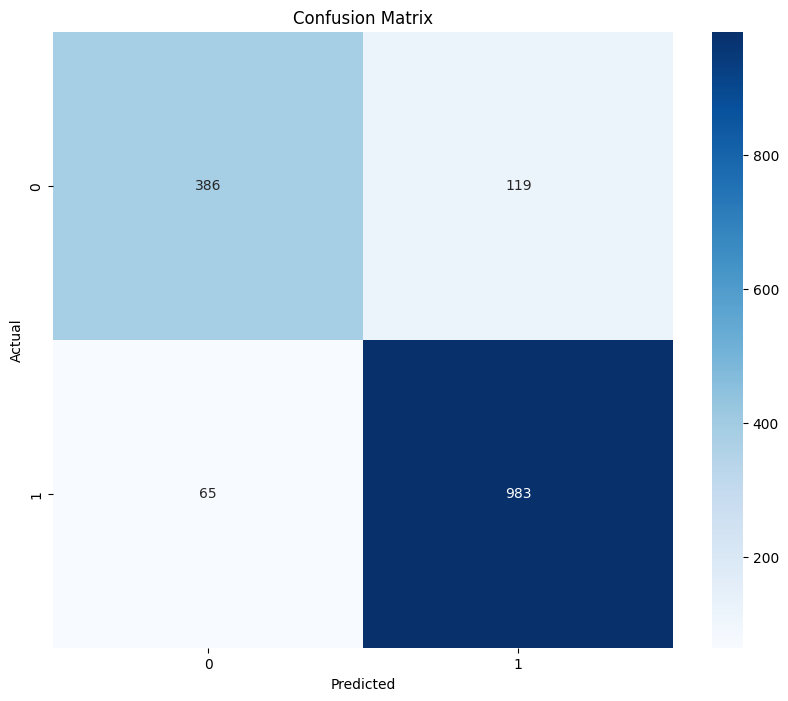

Calculating feature importance...


InvalidParameterError: The 'X' parameter of permutation_importance must be an array-like. Got <6212x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 191102 stored elements in Compressed Sparse Row format> instead.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import jieba
from tqdm import tqdm
import joblib

def preprocess_text(text):
    return ' '.join(jieba.cut(text))

def load_and_preprocess_data(file_path):
    print("Loading and preprocessing data...")
    data = pd.read_csv(file_path, encoding='utf-8')
    data = data.dropna(subset=['review'])
    data['processed_review'] = data['review'].apply(preprocess_text)

    X_train, X_test, y_train, y_test = train_test_split(
        data['processed_review'], data['label'], test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test, data

def train_model(X_train, y_train):
    print("Training model...")
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)

    model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
    model.fit(X_train_tfidf, y_train)

    return model, vectorizer

def evaluate_model(model, vectorizer, X_test, y_test):
    print("Evaluating model...")
    X_test_tfidf = vectorizer.transform(X_test)
    y_pred = model.predict(X_test_tfidf)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def feature_importance(model, vectorizer, X_train, y_train):
    print("Calculating feature importance...")
    X_train_tfidf = vectorizer.transform(X_train)

    perm_importance = permutation_importance(model, X_train_tfidf, y_train, n_repeats=10, random_state=42)

    feature_names = vectorizer.get_feature_names_out()
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': perm_importance.importances_mean
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    print("\nTop 20 important features:")
    print(feature_importance.head(20))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title('Top 20 Feature Importance')
    plt.show()

def error_analysis(model, vectorizer, X_test, y_test, data):
    print("Performing error analysis...")
    X_test_tfidf = vectorizer.transform(X_test)
    y_pred = model.predict(X_test_tfidf)

    errors = X_test[y_pred != y_test]
    true_labels = y_test[y_pred != y_test]
    pred_labels = y_pred[y_pred != y_test]

    print("\nSample of misclassified reviews:")
    for i in range(min(10, len(errors))):
        print(f"True: {true_labels.iloc[i]}, Predicted: {pred_labels[i]}")
        print(data[data['processed_review'] == errors.iloc[i]]['review'].values[0])
        print()

def save_model(model, vectorizer, file_path):
    print("Saving model...")
    joblib.dump((model, vectorizer), file_path)

def load_model(file_path):
    print("Loading model...")
    return joblib.load(file_path)

def predict_sentiment(model, vectorizer, text):
    processed_text = preprocess_text(text)
    tfidf_text = vectorizer.transform([processed_text])
    prediction = model.predict(tfidf_text)[0]
    probability = model.predict_proba(tfidf_text)[0]

    sentiment = "Positive" if prediction == 1 else "Negative"
    confidence = probability[1] if prediction == 1 else probability[0]

    return sentiment, confidence

def main():
    X_train, X_test, y_train, y_test, data = load_and_preprocess_data('ChnSentiCorp_htl_all.csv')

    model, vectorizer = train_model(X_train, y_train)

    evaluate_model(model, vectorizer, X_test, y_test)

    feature_importance(model, vectorizer, X_train, y_train)

    error_analysis(model, vectorizer, X_test, y_test, data)

    save_model(model, vectorizer, 'sentiment_model.joblib')

    # Example of using the model for prediction
    sample_text = "这家酒店的服务很好，房间也很干净，我很满意"
    sentiment, confidence = predict_sentiment(model, vectorizer, sample_text)
    print(f"\nSample text: {sample_text}")
    print(f"Predicted sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2f}")

if __name__ == "__main__":
    main()

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_data(file_path):
    data = pd.read_csv(file_path, encoding='utf-8')
    data = data.dropna(subset=['review'])
    return data

def prepare_data(data, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for review in tqdm(data['review']):
        encoded_dict = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    labels = torch.tensor(data['label'].values)

    return input_ids, attention_masks, labels

def save_model(model, tokenizer, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Saving model to {output_dir}")
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

def train_model(model, train_dataloader, validation_dataloader, epochs=4):
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    best_accuracy = 0
    best_model = None

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)

        model.train()
        total_loss = 0

        for batch in tqdm(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()

            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_attention_mask,
                            labels=b_labels)

            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f'Average training loss: {avg_train_loss:.2f}')

        model.eval()
        eval_accuracy = 0
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_attention_mask)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            eval_accuracy += torch.sum(predictions == b_labels)

        eval_accuracy = eval_accuracy.double() / len(validation_dataloader.dataset)
        print(f'Validation Accuracy: {eval_accuracy:.2f}')

        if eval_accuracy > best_accuracy:
            best_accuracy = eval_accuracy
            best_model = model.state_dict()

    print("Training complete!")
    return best_model, best_accuracy

def evaluate_model(model, test_dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_attention_mask)

        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())

    print(classification_report(true_labels, predictions))

def main():
    # 加载数据
    data = load_data('ChnSentiCorp_htl_all.csv')

    # 加载预训练的中文BERT模型和分词器
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2)
    model.to(device)

    # 准备数据
    input_ids, attention_masks, labels = prepare_data(data, tokenizer)

    # 分割数据集
    train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
        input_ids, attention_masks, labels, random_state=42, test_size=0.2
    )

    # 创建数据加载器
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

    # 训练模型
    best_model_state, best_accuracy = train_model(model, train_dataloader, test_dataloader)

    # 加载最佳模型
    model.load_state_dict(best_model_state)

    # 评估模型
    evaluate_model(model, test_dataloader)

    # 保存最佳模型
    save_model(model, tokenizer, './best_bert_model')

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/7765 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, o

Epoch 1/4
----------


100%|██████████| 195/195 [01:58<00:00,  1.65it/s]


Average training loss: 0.29
Validation Accuracy: 0.89
Epoch 2/4
----------


100%|██████████| 195/195 [01:57<00:00,  1.66it/s]


Average training loss: 0.18
Validation Accuracy: 0.90
Epoch 3/4
----------


100%|██████████| 195/195 [01:57<00:00,  1.66it/s]


Average training loss: 0.11
Validation Accuracy: 0.90
Epoch 4/4
----------


100%|██████████| 195/195 [01:57<00:00,  1.65it/s]


Average training loss: 0.06
Validation Accuracy: 0.90
Training complete!
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       505
           1       0.91      0.94      0.93      1048

    accuracy                           0.90      1553
   macro avg       0.89      0.88      0.88      1553
weighted avg       0.90      0.90      0.90      1553

Saving model to ./best_bert_model


In [54]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from typing import List, Dict, Union

class BERTSentimentAnalyzer:
    def __init__(self, model_path: str):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()

    def preprocess_text(self, text: str) -> Dict[str, torch.Tensor]:
        encoded_dict = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return encoded_dict

    def predict_sentiment(self, text: str) -> Dict[str, Union[str, float]]:
        encoded_dict = self.preprocess_text(text)
        input_ids = encoded_dict['input_ids'].to(self.device)
        attention_mask = encoded_dict['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

        sentiment = "Positive" if prediction == 1 else "Negative"

        return {
            "text": text,
            "sentiment": sentiment,
            "confidence": confidence
        }

    def predict_batch(self, texts: List[str]) -> List[Dict[str, Union[str, float]]]:
        results = []
        for text in texts:
            results.append(self.predict_sentiment(text))
        return results

# 使用示例
if __name__ == "__main__":
    # 假设最佳模型保存在 './best_bert_model' 目录
    analyzer = BERTSentimentAnalyzer('/content/best_bert_model')

    # 测试单个文本
    sample_text = "这台手术很成功，我失败的人生结束了"
    result = analyzer.predict_sentiment(sample_text)
    print("单个文本预测结果:")
    print(f"Text: {result['text']}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['confidence']:.4f}")

    # 测试批量文本
    sample_texts = [
        "鸽子象征着自由，可人们都住进了鸽子笼",
        "毕业一年，经过我的不懈努力，如今的积蓄已经足够自己下半辈子不吃不喝了。",
        "为了不留下遗憾，我带着遗憾离开了那个地方",
        "我是孤独大赛的第一名，也是最后一名"
    ]
    results = analyzer.predict_batch(sample_texts)
    print("\n批量文本预测结果:")
    for result in results:
        print(f"Text: {result['text']}")
        print(f"Sentiment: {result['sentiment']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print()

单个文本预测结果:
Text: 这台手术很成功，我失败的人生结束了
Sentiment: Negative
Confidence: 0.6046

批量文本预测结果:
Text: 鸽子象征着自由，可人们都住进了鸽子笼
Sentiment: Positive
Confidence: 0.9888

Text: 毕业一年，经过我的不懈努力，如今的积蓄已经足够自己下半辈子不吃不喝了。
Sentiment: Positive
Confidence: 0.9966

Text: 为了不留下遗憾，我带着遗憾离开了那个地方
Sentiment: Positive
Confidence: 0.5719

Text: 我是孤独大赛的第一名，也是最后一名
Sentiment: Positive
Confidence: 0.8187



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import jieba
from tqdm import tqdm

def preprocess_text(text):
    return ' '.join(jieba.cut(text))

def load_and_preprocess_data(file_path):
    print("Loading and preprocessing data...")
    data = pd.read_csv(file_path, encoding='utf-8')
    data = data.dropna(subset=['review'])
    data['processed_review'] = data['review'].apply(preprocess_text)

    X_train, X_test, y_train, y_test = train_test_split(
        data['processed_review'], data['label'], test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

def extract_features(X_train, X_test):
    print("Extracting TF-IDF features...")
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf, vectorizer

def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    print(f"Training and evaluating {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    return accuracy, model

def main():
    X_train, X_test, y_train, y_test = load_and_preprocess_data('ChnSentiCorp_htl_all.csv')
    X_train_tfidf, X_test_tfidf, vectorizer = extract_features(X_train, X_test)

    models = {
        'SVM': SVC(kernel='rbf', C=10, gamma='scale', probability=True),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(),
        'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)
    }

    results = {}
    best_model = None
    best_accuracy = 0

    for name, model in models.items():
        accuracy, trained_model = train_and_evaluate(model, X_train_tfidf, X_test_tfidf, y_train, y_test, name)
        results[name] = accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = (name, trained_model)

    print("\nModel Comparison Results:")
    for name, accuracy in results.items():
        print(f"{name}: {accuracy:.4f}")

    print(f"\nBest Model: {best_model[0]} with accuracy {best_accuracy:.4f}")

    # Save the best model
    from joblib import dump
    dump((best_model[1], vectorizer), f'best_model_{best_model[0]}.joblib')
    print(f"Best model saved as 'best_model_{best_model[0]}.joblib'")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Loading and preprocessing data...
Extracting TF-IDF features...
Training and evaluating SVM...
SVM Accuracy: 0.8815
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       505
           1       0.89      0.94      0.91      1048

    accuracy                           0.88      1553
   macro avg       0.87      0.85      0.86      1553
weighted avg       0.88      0.88      0.88      1553

Training and evaluating Random Forest...
Random Forest Accuracy: 0.8384
              precision    recall  f1-score   support

           0       0.86      0.60      0.71       505
           1       0.83      0.95      0.89      1048

    accuracy                           0.84      1553
   macro avg       0.84      0.78      0.80      1553
weighted avg       0.84      0.84      0.83      1553

Training and evaluating XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:06:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8513
              precision    recall  f1-score   support

           0       0.82      0.70      0.75       505
           1       0.86      0.93      0.89      1048

    accuracy                           0.85      1553
   macro avg       0.84      0.81      0.82      1553
weighted avg       0.85      0.85      0.85      1553

Training and evaluating LightGBM...
[LightGBM] [Info] Number of positive: 4274, number of negative: 1938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50776
[LightGBM] [Info] Number of data points in the train set: 6212, number of used features: 1531
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.688023 -> initscore=0.790894
[LightGBM] [Info] Start training from score 0.790894
LightGBM Accuracy: 0.8564
              precision    rec